In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:

import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from  matplotlib.patches import Polygon
from IPython.display import Image
import imageio.v2
import csv

import tqdm as tqdm
import jax 
jax.config.update('jax_platform_name', 'cpu')

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

from iLQR import iLQR, Path



In [8]:
def load_path(filepath: str):
    """
    Gets the centerline of the track from the trajectory data. We currently only
    support 2D track.

    Args:
        filepath (str): the path to file consisting of the centerline position.

    Returns:
        np.ndarray: centerline, of the shape (2, N).
    """
    x = []
    y = []
    with open(filepath) as f:
        spamreader = csv.reader(f, delimiter=',')
        for i, row in enumerate(spamreader):
            if i > 0:
                x.append(float(row[0]))
                y.append(float(row[1]))

    return np.array([x, y])

Update from  49.22922  to  35.23501 reg:  1.0 alpha:  1.0 2.3729755878448486
Update from  35.23501  to  32.687115 reg:  0.5 alpha:  1.0 2.376664400100708
Update from  32.687115  to  32.672802 reg:  0.25 alpha:  0.1 2.382014513015747
[[1.89      1.8807688 1.8490862 1.7958418 1.7204233 1.6227062 1.5041949
  1.3676358 1.2167373 1.0566188]]
Update from  87.05648  to  86.04733 reg:  1.0 alpha:  0.1 0.017018795013427734
Update from  86.04733  to  84.44868 reg:  0.5 alpha:  0.1 0.025054931640625
Update from  84.44868  to  82.99252 reg:  0.25 alpha:  0.1 0.033144474029541016
Update from  82.99252  to  81.79851 reg:  0.125 alpha:  0.1 0.041201114654541016
Update from  81.79851  to  80.86171 reg:  0.0625 alpha:  0.1 0.04966139793395996
Update from  80.86171  to  80.15582 reg:  0.03125 alpha:  0.1 0.05769205093383789
Update from  80.15582  to  79.61891 reg:  0.015625 alpha:  0.1 0.06568670272827148
Update from  79.61891  to  79.23103 reg:  0.0078125 alpha:  0.1 0.07367897033691406
Update from  79

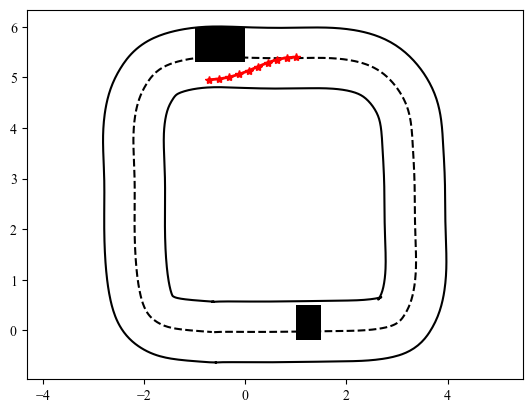

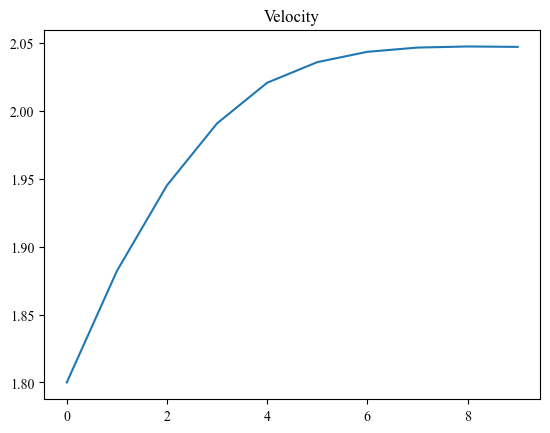

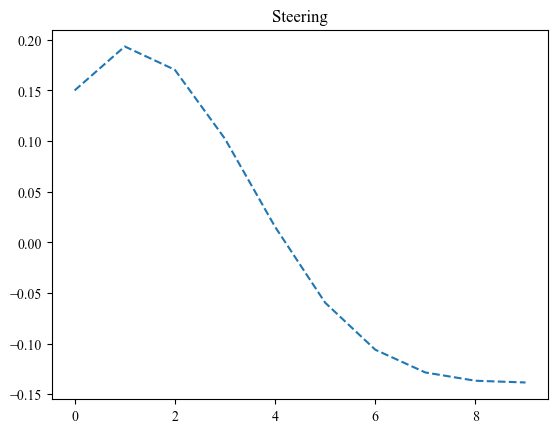

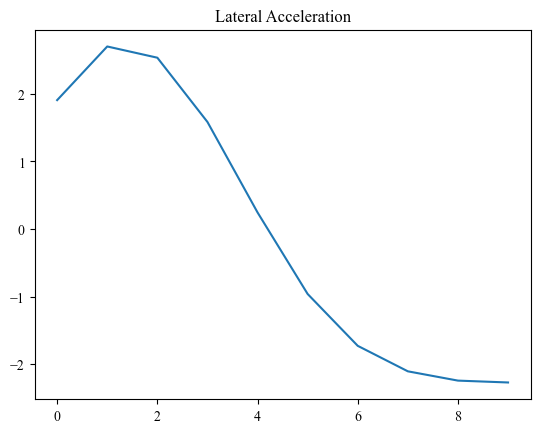

In [183]:
centerline = load_path('outerloop_center_smooth.csv')
path = Path(centerline, 0.6, 0.6, loop=True)
solver = iLQR()
# # make some obstacles
obs1 = np.array([[-1, -1, -0, -0], [5.3, 6.0, 6.0, 5.3]]).T
obs2 = np.array([[1, 1, 1.5, 1.5], [-0.2, 0.5, 0.5, -0.2]]).T
obs_list = [[obs1 for _ in range(10)], [obs2 for _ in range(10)]]
solver.update_obstacles(obs_list)
solver.update_path(path)

x_cur = np.array([1, 5.4, 1.8, 3.14, 0.15])
plan = solver.plan(x_cur)

path.plot_track()
path.plot_track_center()
plt.plot(plan['states'][0, :], plan['states'][1, :], 'r-*', linewidth=2)

p = Polygon(obs1, facecolor = 'k')
plt.gca().add_patch(p)
plt.axis('equal')

p = Polygon(obs2, facecolor = 'k')
plt.gca().add_patch(p)
plt.axis('equal')

print(plan['status'])

plt.figure()
a = plan['states'][2, :] 
plt.plot(a)
plt.title('Velocity')

plt.figure()
# plt.plot(plan['controls'][0,:])
plt.plot(plan['states'][-1,:], '--')
plt.title('Steering')

plt.figure()
a = plan['states'][2, :]**2 / 0.257 * np.tan(plan['states'][-1, :])
plt.plot(a)
plt.title('Lateral Acceleration')

print(plan['t_process'])


iLQR takes : 0.26 sec']: 100%|██████████| 100/100 [00:22<00:00,  4.40it/s]
/tmp/ipykernel_164220/1394010686.py:71: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


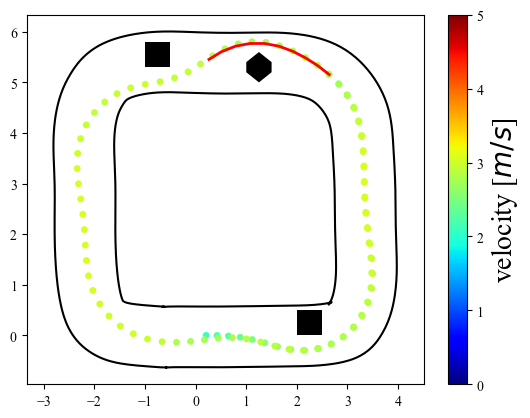

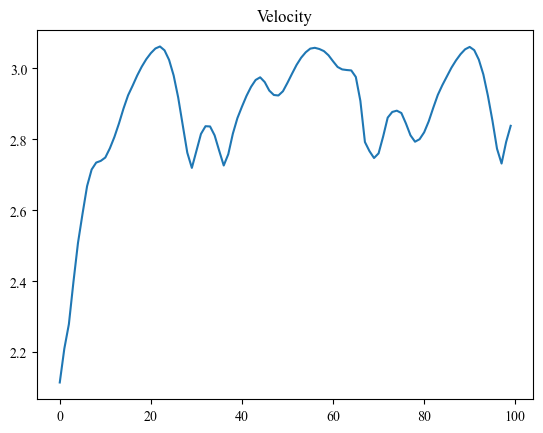

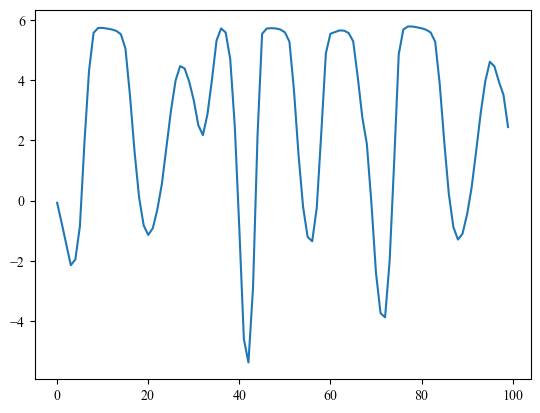

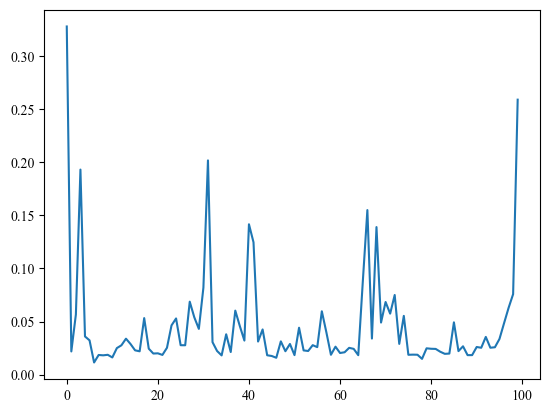

In [16]:
x_cur = np.array([0, 0, 2, 0, 0])  # Initial state.

# Load ILQR
centerline = load_path('outerloop_center_smooth.csv')
path = Path(centerline, 0.6, 0.6, loop=True)

config_file = '/hdd/Git_Repo/PrincetonRaceCar/ROS_Core/src/Planning/ilqr_planning_ros/configs/ilqr.yaml'
solver = iLQR() #(config_file)
solver.update_path(path)

obs1 = np.array([[-1, -1, -0.5, -0.5], [5.3, 5.8, 5.8, 5.3]]).T
obs2 = np.array([[1, 1.25, 1.5, 1.5, 1.25, 1], [5.2, 5.0, 5.2 , 5.4, 5.6, 5.4]]).T
obs3 = np.array([[2.5, 2.5, 2, 2], [-0, 0.5, 0.5, -0]]).T
# obs4 = np.array([[-200, -200, -1.5, -1.5], [0.5, 1, 1, 0.5]]).T
obs_list = [[obs1 for _ in range(10)], 
            [obs2 for _ in range(10)],
            [obs3 for _ in range(10)]]
            # [obs4 for _ in range(10)]]
solver.update_obstacles(obs_list)

# define some parameters
n = 10
itr_receding = 100
init_control = np.zeros((2, n))
fig_prog_folder = 'fig/'

state_history = np.zeros((5,itr_receding))
t_process = np.zeros(itr_receding)
for i in (pbar := tqdm.tqdm(range(itr_receding))):
    
    plan = solver.plan(x_cur, init_control)
    states = plan['states']
    controls = plan['controls']
    x_cur = states[:,1]
    state_history[:,i]  = x_cur
    init_control[:,:-1] = controls[:,1:]
    pbar.set_description(f"iLQR takes : {plan['t_process']:.2f} sec']")
    t_process[i] = plan['t_process']
    # plot
    plt.clf()
    path.plot_track()
    p = Polygon(obs1, facecolor = 'k')
    plt.gca().add_patch(p)

    p = Polygon(obs2, facecolor = 'k')
    plt.gca().add_patch(p)

    p = Polygon(obs3, facecolor = 'k')
    plt.gca().add_patch(p)

    # p = Polygon(obs4, facecolor = 'k')
    # plt.gca().add_patch(p)
    
    sc = plt.scatter(
        state_history[0, :i], state_history[1, :i], s=24,
        c=state_history[2, :i], cmap=cm.jet, vmin=0, vmax=5,
        edgecolor='none', marker='o'
    )
    cbar = plt.colorbar(sc)
    cbar.set_label(r"velocity [$m/s$]", size=20)
    
    plt.plot(states[0, :], states[1, :], 'r', linewidth=2)
    plt.axis('equal')
    plt.savefig(os.path.join(fig_prog_folder, str(i)+".png"), dpi=200)
plt.close('All')

gif_path = os.path.join(fig_prog_folder, 'rollout.gif')
with imageio.get_writer(gif_path, mode='I') as writer:
    for i in range(itr_receding):
        filename = os.path.join(fig_prog_folder, str(i)+".png")
        image = imageio.imread(filename)
        writer.append_data(image)

plt.figure()
plt.plot(state_history[2,:])
plt.title('Velocity')


plt.figure()
a = state_history[2, :]**2 / 0.257 * np.tan(state_history[-1, :])
plt.plot(a)

plt.figure()
plt.plot(t_process)

